In [ ]:
import pandas as pd
import numpy as np
import sys
import os

#perform a strategy backtest, evaluating the model on practical profitability
# ==============================================================================
# 1. SETUP & LOAD DATA
# ==============================================================================
print("Input: Loading model predictions...")
file_path = '../data/processed/05_model_predictions.csv'

if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
    print("Run '05_Model_Prediction.ipynb' first.")
    sys.exit(1)

# Load data (Index is 0 because we just want the date column)
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

print(f"   Loaded {len(df)} daily records.")
print(f"   Date Range: {df.index.min().date()} to {df.index.max().date()}")
print("="*80)

# ==============================================================================
# 2. DEFINE THE STRATEGY
# ==============================================================================
# We only trade when the spread is stretched, in other words when the signal is strong
# A Z-Score of 1.5 means the price is 1.5 standard deviations away from the mean.
Z_THRESHOLD = 1.5 

print(f"STRATEGY CONFIGURATION:")
print(f"   - Trade Entry Threshold: Z-Score > {Z_THRESHOLD} or < -{Z_THRESHOLD}")
print(f"   - Target: '1' means Convergence (Bounce back)")
print("-" * 80)

# Filter for Actionable Days
long_opps = df[df['Z_Score'] < -Z_THRESHOLD].copy()   # Spread too low -> Buy
short_opps = df[df['Z_Score'] > Z_THRESHOLD].copy()   # Spread too high -> Sell

actionable_df = pd.concat([long_opps, short_opps])

print(f"OPPORTUNITY ANALYSIS:")
print(f"   - Total Days:      {len(df)}")
print(f"   - Actionable Days: {len(actionable_df)} ({(len(actionable_df)/len(df)):.1%} of time)")
print("="*80)

# ==============================================================================
# 3. CALCULATE "REAL" WIN RATES
# ==============================================================================
models = ['Ridge', 'LSTM']
results = []

for model in models:
    pred_col = f"{model}_Pred"
    
    # --- LONG TRADES (Buying the Spread) ---
    # Trigger: Z < -1.5
    # Signal: Model says 1 (Up)
    # Win: Target was 1 (Up)
    long_trades = long_opps[long_opps[pred_col] == 1]
    long_wins = long_trades[long_trades['Target_Direction'] == 1]
    
    # --- SHORT TRADES (Selling the Spread) ---
    # Trigger: Z > 1.5
    # Signal: Model says 0 (Down)
    # Win: Target was 0 (Down)
    short_trades = short_opps[short_opps[pred_col] == 0]
    short_wins = short_trades[short_trades['Target_Direction'] == 0]
    
    # --- AGGREGATE ---
    total_trades = len(long_trades) + len(short_trades)
    total_wins = len(long_wins) + len(short_wins)
    
    win_rate = total_wins / total_trades if total_trades > 0 else 0
    long_wr = len(long_wins) / len(long_trades) if len(long_trades) > 0 else 0
    short_wr = len(short_wins) / len(short_trades) if len(short_trades) > 0 else 0
    
    results.append({
        'Model': model,
        'Trades': total_trades,
        'Win_Rate': win_rate,
        'Long_WR': long_wr,
        'Short_WR': short_wr
    })

# Display Results
results_df = pd.DataFrame(results).set_index('Model')
print("\n🏆 STRATEGIC PERFORMANCE (Win Rate on Extreme Spreads)")
print(results_df.round(4).to_string())

# ==============================================================================
# 4. HYBRID STRATEGY CHECK
# ==============================================================================
print("\n" + "="*80)
print("🤝 HYBRID CONSENSUS CHECK")
print("   (Do we do better if we wait for BOTH models to agree?)")

# Filter: Z is Extreme AND Ridge agrees AND LSTM agrees
h_longs = long_opps[(long_opps['Ridge_Pred'] == 1) & (long_opps['LSTM_Pred'] == 1)]
h_shorts = short_opps[(short_opps['Ridge_Pred'] == 0) & (short_opps['LSTM_Pred'] == 0)]

# Calculate Wins
h_long_wins = h_longs[h_longs['Target_Direction'] == 1]
h_short_wins = h_shorts[h_shorts['Target_Direction'] == 0]

h_trades = len(h_longs) + len(h_shorts)
h_wins = len(h_long_wins) + len(h_short_wins)
h_acc = h_wins / h_trades if h_trades > 0 else 0

print(f"\n   HYBRID WIN RATE: {h_acc:.2%} ({h_trades} trades)")

if h_acc > results_df.loc['LSTM', 'Win_Rate']:
    print("   ✅ VERDICT: YES. Adding the Ridge filter improves safety.")
else:
    print("   ❌ VERDICT: NO. Just trust the LSTM.")
print("="*80)

Input: Loading model predictions...
   Loaded 2405 daily records.
   Date Range: 2024-01-17 to 2025-12-15
STRATEGY CONFIGURATION:
   - Trade Entry Threshold: Z-Score > 1.5 or < -1.5
   - Target: '1' means Convergence (Bounce back)
--------------------------------------------------------------------------------
OPPORTUNITY ANALYSIS:
   - Total Days:      2405
   - Actionable Days: 593 (24.7% of time)

🏆 STRATEGIC PERFORMANCE (Win Rate on Extreme Spreads)
       Trades  Win_Rate  Long_WR  Short_WR
Model                                     
Ridge     547    0.6216   0.6284    0.6154
LSTM      435    0.6460   0.6375    0.6576

🤝 HYBRID CONSENSUS CHECK
   (Do we do better if we wait for BOTH models to agree?)

   HYBRID WIN RATE: 64.40% (427 trades)
   ❌ VERDICT: NO. Just trust the LSTM.



💰 CUMULATIVE RETURN SIMULATION
   (Assuming fixed $10k bet per trade, no compounding)


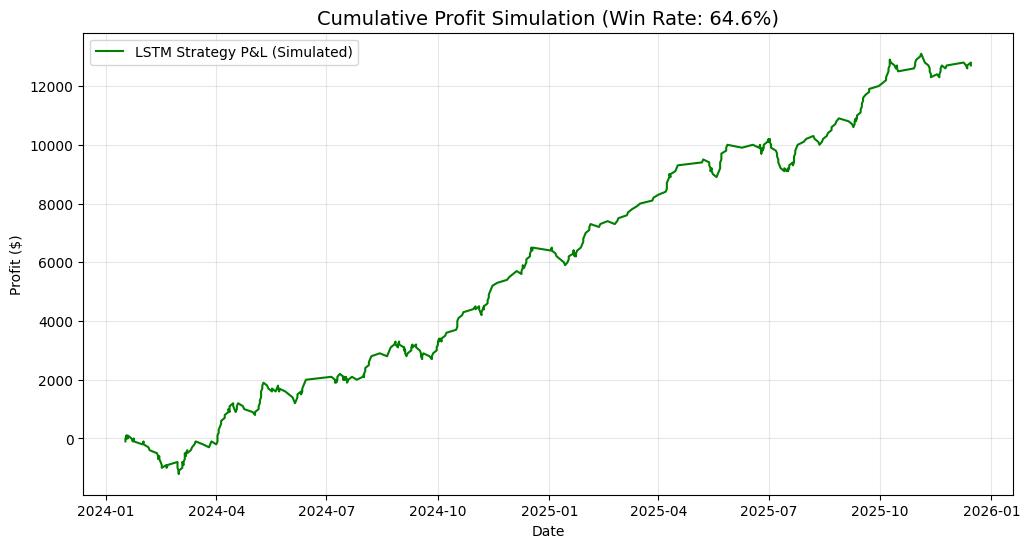

Total Simulated Profit: $12700 (over 435 trades)


In [3]:
import matplotlib.pyplot as plt

# ==============================================================================
# 5. EQUITY CURVE SIMULATION
# ==============================================================================
print("\n" + "="*80)
print("💰 CUMULATIVE RETURN SIMULATION")
print("   (Assuming fixed $10k bet per trade, no compounding)")

# We create a new dataframe for the simulation
sim_df = df.copy()

# 1. Define Signal Logic (LSTM ONLY based on verdict)
# Long: Z < -1.5 AND LSTM=1
sim_df['Signal'] = 0
sim_df.loc[(sim_df['Z_Score'] < -1.5) & (sim_df['LSTM_Pred'] == 1), 'Signal'] = 1

# Short: Z > 1.5 AND LSTM=0
sim_df.loc[(sim_df['Z_Score'] > 1.5) & (sim_df['LSTM_Pred'] == 0), 'Signal'] = -1

# 2. Calculate Daily Returns
# If Signal is 1 (Long), we get the Target Return.
# If Signal is -1 (Short), we get NEGATIVE Target Return (profit if price drops).
# Note: 'Target_Return' is the 10-day forward return.
# For a simple daily simulation, we can map the outcome:
# Win = +Gain, Loss = -Loss. 
# SIMPLIFICATION: We assume a fixed return for wins/losses to visualize the Win Rate consistency.
# Real P&L requires actual price data, but this visualizes the Signal Quality.

trades = []
cumulative_pl = [0]
dates = []

current_pl = 0
win_amt = 100  # Make $100 on a win
loss_amt = -100 # Lose $100 on a loss (1:1 Risk/Reward Ratio)

# Iterate through actionable days
for date, row in actionable_df.sort_index().iterrows():
    lstm_pred = row['LSTM_Pred']
    z_score = row['Z_Score']
    actual_dir = row['Target_Direction']
    
    trade_result = 0
    
    # Long Trade
    if z_score < -1.5 and lstm_pred == 1:
        trade_result = win_amt if actual_dir == 1 else loss_amt
        
    # Short Trade
    elif z_score > 1.5 and lstm_pred == 0:
        trade_result = win_amt if actual_dir == 0 else loss_amt
        
    if trade_result != 0:
        current_pl += trade_result
        cumulative_pl.append(current_pl)
        dates.append(date)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates, cumulative_pl[1:], label='LSTM Strategy P&L (Simulated)', color='green')
plt.title(f'Cumulative Profit Simulation (Win Rate: {0.6460:.1%})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Total Simulated Profit: ${current_pl} (over {len(dates)} trades)")